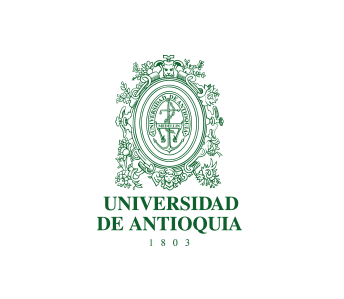

# Proyecto 2: Análisis de señales ECG y detección de arritmias - análisis espectral

Estudiantes:
- Juan Camilo Carvajal Sierra - 1010124738
- Ana María Uribe Betancur - 1000537653
- Duvan Vega Cardona - 1003896233

# Parte 2: Fundamentación teórica e implementación

In [ ]:
from scipy import stats
from scipy.stats import levene, shapiro, ttest_ind, mannwhitneyu
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, filtfilt
import scipy.fftpack as sp
from scipy.signal import find_peaks
from scipy.fftpack import dct
from scipy import signal

In [ ]:
file_id2 = '1IhCUZRzL8RkBqlRPpY5boBzukPkjOIqM'
destination2 = 'Diagnostics.xlsx'

!gdown --id {file_id2} --output {destination2}

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IhCUZRzL8RkBqlRPpY5boBzukPkjOIqM
To: /content/Diagnostics.xlsx
100% 976k/976k [00:00<00:00, 120MB/s]


In [ ]:
# Se realiza la carga de archivos al entorno
file_id = '1tGXh5G3DEOshn6DA28nioFCQv7ZX0e0l'
destination = 'ECGDataDenoised.zip'

!gdown --id {file_id} --output {destination}

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1tGXh5G3DEOshn6DA28nioFCQv7ZX0e0l
From (redirected): https://drive.google.com/uc?id=1tGXh5G3DEOshn6DA28nioFCQv7ZX0e0l&confirm=t&uuid=a9c30e2b-6e6b-4bec-9f06-9cf2259c88cc
To: /content/ECGDataDenoised.zip
100% 2.01G/2.01G [00:24<00:00, 81.1MB/s]


In [ ]:
datos = pd.read_excel('Diagnostics.xlsx')
# Observación preliminar de las variables y estructura del dataset
datos.describe()

,PatientAge,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
count,10646.000000,10646.000000,10646.00000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000
mean,59.186831,84.136107,92.57787,90.989292,384.150855,434.154048,39.620609,44.637704,13.839470,219.260567,264.755213,411.335995
std,18.030019,34.455349,60.09394,17.479540,59.226289,39.354182,41.212648,57.478092,5.676339,6.410413,8.362120,29.777404
min,4.000000,34.000000,0.00000,18.000000,114.000000,219.000000,-89.000000,-89.000000,5.000000,159.000000,249.000000,281.000000
25%,49.000000,57.000000,57.00000,80.000000,344.000000,408.000000,14.000000,19.000000,9.000000,216.000000,259.000000,392.000000
50%,62.000000,73.000000,72.00000,88.000000,390.000000,430.000000,46.000000,42.000000,12.000000,219.000000,264.000000,414.000000
75%,72.000000,104.000000,106.00000,98.000000,426.000000,456.000000,68.000000,62.000000,17.000000,224.000000,268.000000,432.000000
max,98.000000,263.000000,535.00000,256.000000,736.000000,760.000000,270.000000,270.000000,40.000000,240.000000,331.000000,582.000000


In [ ]:
datos = pd.read_excel('Diagnostics.xlsx')
datos_filtrados = datos[datos['Rhythm'] != 'SR']
datos_2 = datos_filtrados[(datos_filtrados['PatientAge'] >= 18) & (datos_filtrados['PatientAge'] <= 90)]
datos_finales = datos_2[(datos_2['Rhythm'] != 'AVNRT') & (datos_2['Rhythm'] != 'AVRT') & (datos_2['Rhythm'] != 'SAAWR')]

### **1.**
Estudiar, entender, explicar paso a paso e implementar la extracción de
características usando la transformada discreta de Fourier (5%)

In [ ]:
# 1. Importación de las señales de ECG
# Se extraen los archivos en una carpeta dentro del entorno
import zipfile
zip_path = "ECGDataDenoised.zip"
extract_to = "ecg_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [ ]:
# 2. Preprocesamiento de datos. En esta ocación omitimos este paso dado que estamos usando un DataSet que posee datos procesados
#  2.1. Filtro FIR de paso de banda con ventana Kaiser-Bessel entre 8 y 20 Hz
#  2.2. Esto elimina el ruido muscular y maximiza los complejos QRS
#  2.3. Eliminación de la línea base y los artefactos de movimiento

# 3. Extracción de características por medio de la transformada rápida de Fourier (FFT) que es una implementación rápida y eficiente de la DFT.

def analyze_ecg_fft_from_folder(folder_path, file_index, fs=500):
    """
    Parámetros:
    - folder_path (str): Ruta a la carpeta con los archivos ECG.
    - file_index (int): Índice del archivo (comenzando desde 0).
    - fs (int): Frecuencia de muestreo (default: 500 Hz).
    """

    # Obtener lista de archivos válidos
    files = sorted([f for f in os.listdir(folder_path) if not f.startswith('.')])
    if file_index < 0 or file_index >= len(files):
        raise IndexError("El índice del archivo está fuera del rango válido.")

    file_path = os.path.join(folder_path, files[file_index])
    print(f"Cargando archivo: {files[file_index]}")

    # Cargar señal (intenta leer como CSV, si falla usa espacios por defecto)
    try:
        ecg_data = np.loadtxt(file_path, delimiter=',')
    except:
        ecg_data = np.loadtxt(file_path)

    # Extraer la derivación II
    ecg_signal = ecg_data[:, 1]
    N = len(ecg_signal)
    t = np.linspace(0, N/fs, N)

    # FFT
    fft_result = np.fft.fft(ecg_signal)
    freqs = np.fft.fftfreq(N, d=1/fs)

    # Mantener solo la mitad positiva del espectro
    freqs_pos = freqs[:N//2]
    fft_half = fft_result[:N//2]

    # Calcular magnitud y fase
    magnitude = np.abs(fft_half)
    magnitude_db = 20 * np.log10(magnitude + 1e-10)  # evitar log(0)
    phase_rad = np.angle(fft_half)
    phase_deg = np.degrees(phase_rad)

    plt.figure(figsize=(15, 5))

    # Señal en el tiempo
    plt.subplot(1, 2, 1)
    plt.plot(t, ecg_signal, color='blue')
    plt.title("Señal ECG en el tiempo")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud (mV)")
    plt.grid(True)

    # Magnitud en dB
    plt.subplot(1, 2, 2)
    plt.plot(freqs_pos, magnitude_db, color='red')
    plt.title("Espectro de magnitud")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Magnitud (dB)")
    plt.grid(True)

    # Fase en grados
    # plt.subplot(1, 3, 3)
    # plt.plot(freqs_pos, phase_deg, color='green')
    # plt.title("Fase en el dominio de la frecuencia")
    # plt.xlabel("Frecuencia (Hz)")
    # plt.ylabel("Fase (°)")
    # plt.grid(True)

    plt.tight_layout()
    plt.show()

Cargando archivo: MUSE_20180111_164220_32000.csv


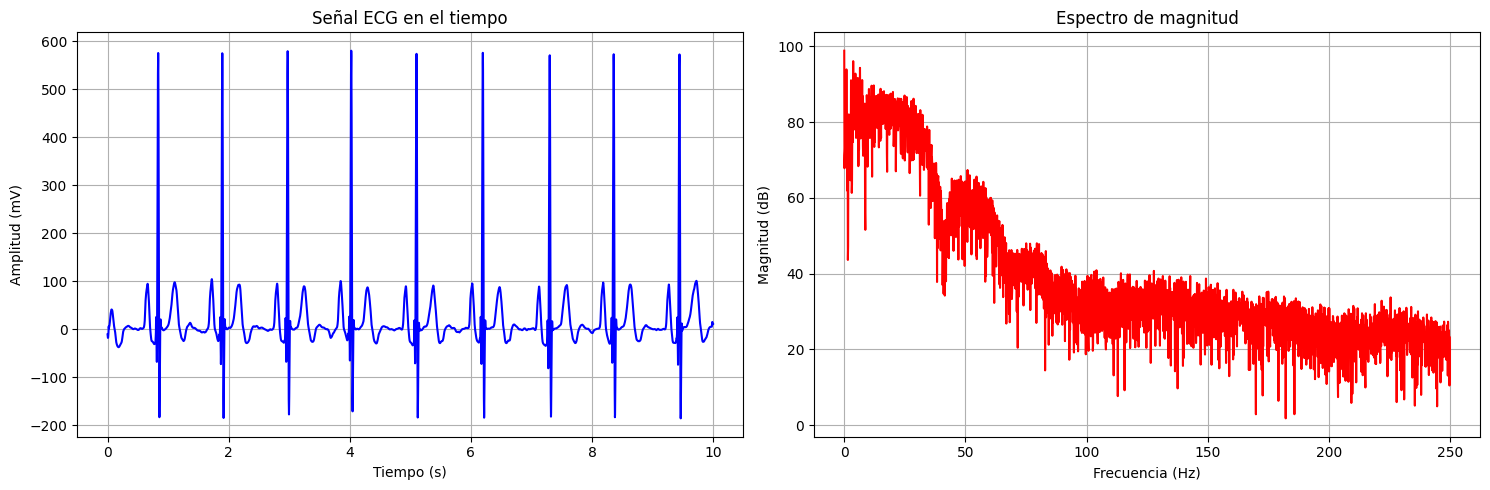

In [ ]:
ruta_carpeta = "/content/ecg_data/ECGDataDenoised"
analyze_ecg_fft_from_folder(ruta_carpeta, file_index=84, fs=500)

In [ ]:
!pip install py-ecg-detectors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.5/554.5 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43804 sha256=255bd5ba823ced0cd2b95a4d681ef8608e158d5f3b22593415c3fc1288e73ae9
  Stored in directory: /root/.cache/pip/wheels/4c/f6/62/023194c77c6e9a7c3316fd0052706cedacebe136926fb99332
Successfully built gatspy


In [ ]:
from scipy.signal import welch
from scipy.integrate import trapezoid
from scipy.stats import entropy
from tqdm import tqdm
from ecgdetectors import Detectors

# Inicializar
features = []
señales_descartadas = []
data_path = "ecg_data/ECGDataDenoised/"
fs = 500  # frecuencia de muestreo en Hz
qrs_band = (5, 15)
detectors = Detectors(sampling_frequency=fs)

def calcular_nn_intervals(r_peaks, sampling_rate=500):
    return np.diff(r_peaks) * 1000 / sampling_rate  # en milisegundos

def detectar_r_pyecg(signal):
    return detectors.hamilton_detector(signal.to_numpy())

# Iterar sobre todos los registros
for _, row in tqdm(datos_finales.iterrows(), total=len(datos_finales), desc="Procesando ECGs"):
    archivo = f"{row['FileName']}.csv"
    file_path = os.path.join(data_path, archivo)

    if not os.path.exists(file_path):
        print(f"Archivo no encontrado: {archivo}")
        continue

    try:
        # Cargar la señal ECG
        signal = pd.read_csv(file_path, header=None).iloc[:, 1]

        # Detectar picos R y calcular NN intervals
        r_peaks = detectar_r_pyecg(signal)
        nn_intervals = calcular_nn_intervals(r_peaks)

        if len(nn_intervals) > 2:
            # Calcular PSD
            f, psd = welch(signal, fs=fs, nperseg=1024)

            # 1. Frecuencia pico
            idx_max = np.argmax(psd)
            frecuencia_pico = f[idx_max]

            # 2. Energía total
            energia_total = trapezoid(psd, f)

            # 3. Energía en la banda del QRS
            idx_qrs = np.where((f >= qrs_band[0]) & (f <= qrs_band[1]))
            energia_banda_qrs = trapezoid(psd[idx_qrs], f[idx_qrs])

            # 4. Relación armónicos
            margen = 5
            pico_central = f[idx_max]
            idx_fuera = np.where((f < pico_central - margen) | (f > pico_central + margen))
            energia_fuera = trapezoid(psd[idx_fuera], f[idx_fuera])
            relacion_armonicos = energia_fuera / energia_total if energia_total > 0 else 0

            # 5. Entropía espectral
            psd_norm = psd / np.sum(psd)
            psd_norm = psd_norm[psd_norm > 0]  # eliminar ceros
            entropia_espectral = entropy(psd_norm, base=2)

            # 6. Ancho de banda espectral
            centroide = np.sum(f * psd) / np.sum(psd)
            ancho_banda = np.sqrt(np.sum(((f - centroide) ** 2) * psd) / np.sum(psd))

            # Buscar etiqueta
            tipo_arritmia = row['Rhythm'] if 'Rhythm' in row else np.nan

            # Agregar al DataFrame
            features.append({
                'FileName': archivo,
                'frecuencia_pico': frecuencia_pico,
                'energia_total': energia_total,
                'energia_banda_QRS': energia_banda_qrs,
                'relacion_armonicos': relacion_armonicos,
                'entropia_espectral': entropia_espectral,
                'ancho_banda_espectral': ancho_banda,
                'ritmo': tipo_arritmia
            })
        else:
            señales_descartadas.append((signal, row["FileName"]))

    except Exception as e:
        print(f"Error procesando {archivo}: {e}")
        señales_descartadas.append((signal, row["FileName"]))

# Crear DataFrame final
df_features = pd.DataFrame(features)

# Mostrar resultados
display(df_features.head())
print(f"Total de señales procesadas: {len(df_features)}")
print(f"Total de señales descartadas: {len(señales_descartadas)}")

Procesando ECGs: 100%|██████████| 8420/8420 [03:09<00:00, 44.53it/s]


,FileName,frecuencia_pico,energia_total,energia_banda_QRS,relacion_armonicos,entropia_espectral,ancho_banda_espectral,ritmo
0,MUSE_20180113_171327_27000.csv,13.183594,6103.737627,3817.016716,0.978267,5.336861,5.596169,AFIB
1,MUSE_20180112_073319_29000.csv,3.417969,14882.863336,7018.030326,0.454985,5.552608,6.619798,SB
2,MUSE_20180111_165520_97000.csv,4.394531,15853.385122,6651.535409,0.386303,5.475615,7.345209,SA
3,MUSE_20180113_121940_44000.csv,3.417969,19269.533394,8982.134907,0.385043,5.384178,6.213568,SB
4,MUSE_20180112_122850_57000.csv,5.371094,19011.002658,8130.496952,1.262300,5.047794,9.238748,AF


Total de señales procesadas: 8380
Total de señales descartadas: 40


### **2.**
Estudiar, entender, explicar paso a paso e implementar la extracción
de características usando la transformada discreta del coseno (5%)

Ejemplo: Análisis de archivo individual
Procesando archivo: MUSE_20180111_164220_32000.csv


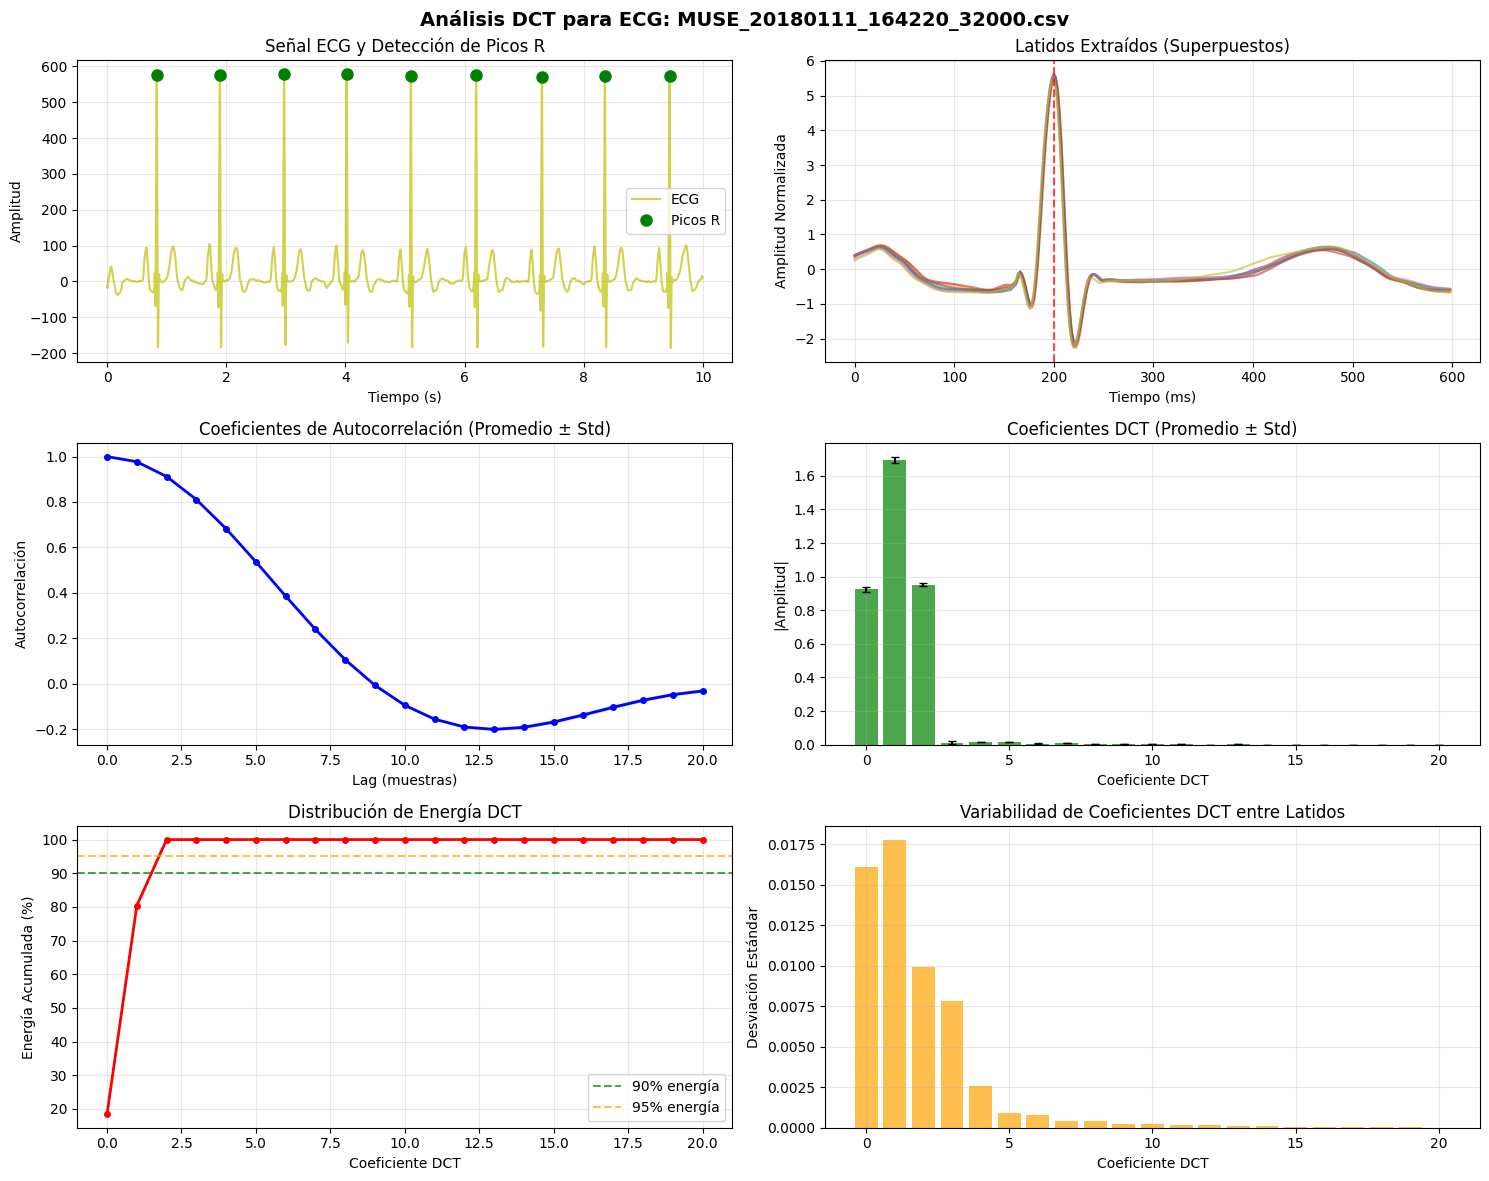


RESUMEN DE CARACTERÍSTICAS DCT
Archivo procesado: MUSE_20180111_164220_32000.csv
Latidos analizados: 9
Frecuencia cardíaca: 54.0 BPM

Coeficientes DCT más significativos:
  DCT[ 0]:   0.9244 ± 0.0161
  DCT[ 1]:   1.6928 ± 0.0178
  DCT[ 2]:   0.9522 ± 0.0099
  DCT[ 3]:   0.0124 ± 0.0078
  DCT[ 4]:  -0.0162 ± 0.0026
  DCT[ 5]:  -0.0143 ± 0.0009
  DCT[ 6]:  -0.0071 ± 0.0008
  DCT[ 7]:  -0.0080 ± 0.0004
  DCT[ 8]:  -0.0033 ± 0.0004
  DCT[ 9]:  -0.0046 ± 0.0002

90% de la energía concentrada en primeros 3 coeficientes


In [ ]:
import warnings
warnings.filterwarnings('ignore')

def ecg_dct_feature_extraction(file_index, ecg_data_path="/content/ecg_data/ECGDataDenoised",
                              fs=500, show_plots=True, return_all_data=False):
    """
    Parámetros:
    -----------
    file_index : int
        Índice del archivo ECG a procesar (0-based)
    ecg_data_path : str
        Ruta a la carpeta con archivos ECG
    fs : int
        Frecuencia de muestreo (Hz)
    show_plots : bool
        Si mostrar gráficas del procesamiento
    return_all_data : bool
        Si retornar datos intermedios para análisis

    Retorna:
    --------
    dict : Diccionario con características DCT y datos del procesamiento
    """

    #-----------------------------------------
    # 1. CARGAR DATOS ECG
    #-----------------------------------------
    try:
        # Obtener lista de archivos
        files = sorted([f for f in os.listdir(ecg_data_path) if f.endswith('.csv')])
        if file_index >= len(files):
            raise ValueError(f"Índice {file_index} excede el número de archivos ({len(files)})")

        file_path = os.path.join(ecg_data_path, files[file_index])
        print(f"Procesando archivo: {files[file_index]}")

        # Cargar señal ECG
        ecg_data = pd.read_csv(file_path).values
        ecg_signal = ecg_data[:, 1]  # Derivación II (segunda columna)

    except Exception as e:
        raise ValueError(f"Error al cargar archivo: {e}")

    #-----------------------------------------
    # 2. PREPROCESAMIENTO: FILTRO BUTTERWORTH PASA BANDA (1-40 Hz)
    #-----------------------------------------
    ecg_filtered = ecg_signal

    #-----------------------------------------
    # 3. DETECCIÓN DE PICOS R
    #-----------------------------------------
    # Normalizar señal para detección
    ecg_norm = (ecg_filtered - np.mean(ecg_filtered)) / np.std(ecg_filtered)

    # Parámetros para detección de picos R
    # Altura mínima: 60% del máximo
    # Distancia mínima: 0.6 * frecuencia cardíaca promedio esperada
    min_distance = int(0.6 * fs / (120/60))  # 120 BPM máximo esperado
    height_threshold = 0.6 * np.max(ecg_norm)

    # Encontrar picos R
    r_peaks, _ = find_peaks(ecg_norm, height=height_threshold, distance=min_distance)

    if len(r_peaks) < 3:
        raise ValueError("Insuficientes picos R detectados para el análisis")

    #-----------------------------------------
    # 4. EXTRACCIÓN DE LATIDOS Y AUTOCORRELACIÓN
    #-----------------------------------------
    # Definir ventana de latido: 200ms antes y 400ms después del pico R
    before_r = int(0.2 * fs)  # 200ms antes
    after_r = int(0.4 * fs)   # 400ms después
    beat_length = before_r + after_r

    beats = []
    autocorr_coeffs = []

    for i, r_peak in enumerate(r_peaks):
        # Verificar límites
        start_idx = r_peak - before_r
        end_idx = r_peak + after_r

        if start_idx >= 0 and end_idx < len(ecg_filtered):
            # Extraer latido
            beat = ecg_filtered[start_idx:end_idx]

            # Normalizar latido
            beat = (beat - np.mean(beat)) / (np.std(beat) + 1e-8)
            beats.append(beat)

            # Calcular autocorrelación (21 coeficientes)
            autocorr = np.correlate(beat, beat, mode='full')
            autocorr = autocorr[len(autocorr)//2:]  # Solo lag positivo

            # Normalizar autocorrelación
            autocorr = autocorr / autocorr[0]  # Normalizar por el valor en lag=0

            # Tomar primeros 21 coeficientes
            if len(autocorr) >= 21:
                autocorr_coeffs.append(autocorr[:21])

    if len(autocorr_coeffs) == 0:
        raise ValueError("No se pudieron extraer latidos válidos")

    #-----------------------------------------
    # 5. APLICAR DCT A LOS COEFICIENTES DE AUTOCORRELACIÓN
    #-----------------------------------------
    dct_features = []
    for autocorr in autocorr_coeffs:
        # Aplicar DCT tipo-II (la más común)
        dct_coeffs = dct(autocorr, type=2, norm='ortho')
        dct_features.append(dct_coeffs)

    dct_features = np.array(dct_features)

    # Calcular estadísticas de las características DCT
    dct_mean = np.mean(dct_features, axis=0)
    dct_std = np.std(dct_features, axis=0)

    #-----------------------------------------
    # 6. CREAR GRÁFICAS
    #-----------------------------------------
    if show_plots:
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        fig.suptitle(f'Análisis DCT para ECG: {files[file_index]}', fontsize=14, fontweight='bold')

        # Tiempo para gráficas
        time_original = np.arange(len(ecg_signal)) / fs
        time_beat = np.arange(beat_length) / fs * 1000  # en ms

        # Gráfica 1: Señal original vs filtrada
        axes[0,0].plot(time_original, ecg_signal, 'y-', alpha=0.7, label='ECG')
        # axes[0,0].plot(time_original, ecg_filtered, 'r-', label='Filtrada (1-40 Hz)')
        axes[0,0].plot(r_peaks/fs, ecg_filtered[r_peaks], 'go', markersize=8, label='Picos R')
        axes[0,0].set_xlabel('Tiempo (s)')
        axes[0,0].set_ylabel('Amplitud')
        axes[0,0].set_title('Señal ECG y Detección de Picos R')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # Gráfica 2: Latidos superpuestos
        axes[0,1].set_title('Latidos Extraídos (Superpuestos)')
        for i, beat in enumerate(beats[:min(10, len(beats))]):  # Máximo 10 latidos
            axes[0,1].plot(time_beat, beat, alpha=0.6, label=f'Latido {i+1}' if i < 5 else "")
        axes[0,1].axvline(x=before_r/fs*1000, color='r', linestyle='--', alpha=0.7, label='Pico R')
        axes[0,1].set_xlabel('Tiempo (ms)')
        axes[0,1].set_ylabel('Amplitud Normalizada')
        if len(beats) <= 5:
            axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # Gráfica 3: Coeficientes de autocorrelación promedio
        autocorr_mean = np.mean(autocorr_coeffs, axis=0)
        autocorr_std = np.std(autocorr_coeffs, axis=0)
        lags = np.arange(21)

        axes[1,0].plot(lags, autocorr_mean, 'b-o', linewidth=2, markersize=4)
        axes[1,0].fill_between(lags, autocorr_mean - autocorr_std,
                              autocorr_mean + autocorr_std, alpha=0.3)
        axes[1,0].set_xlabel('Lag (muestras)')
        axes[1,0].set_ylabel('Autocorrelación')
        axes[1,0].set_title('Coeficientes de Autocorrelación (Promedio ± Std)')
        axes[1,0].grid(True, alpha=0.3)

        # Gráfica 4: Coeficientes DCT promedio
        coeff_indices = np.arange(21)
        axes[1,1].bar(coeff_indices, np.abs(dct_mean), alpha=0.7, color='green')
        axes[1,1].errorbar(coeff_indices, np.abs(dct_mean), yerr=dct_std,
                          fmt='none', color='black', capsize=3)
        axes[1,1].set_xlabel('Coeficiente DCT')
        axes[1,1].set_ylabel('|Amplitud|')
        axes[1,1].set_title('Coeficientes DCT (Promedio ± Std)')
        axes[1,1].grid(True, alpha=0.3)

        # Gráfica 5: Distribución de energía DCT
        energy_cumsum = np.cumsum(dct_mean**2) / np.sum(dct_mean**2) * 100
        axes[2,0].plot(coeff_indices, energy_cumsum, 'r-o', linewidth=2, markersize=4)
        axes[2,0].axhline(y=90, color='g', linestyle='--', alpha=0.7, label='90% energía')
        axes[2,0].axhline(y=95, color='orange', linestyle='--', alpha=0.7, label='95% energía')
        axes[2,0].set_xlabel('Coeficiente DCT')
        axes[2,0].set_ylabel('Energía Acumulada (%)')
        axes[2,0].set_title('Distribución de Energía DCT')
        axes[2,0].legend()
        axes[2,0].grid(True, alpha=0.3)

        # Gráfica 6: Variabilidad de coeficientes DCT entre latidos
        if len(dct_features) > 1:
            # Mostrar variabilidad de los primeros 10 coeficientes más importantes
            coeff_variability = np.std(dct_features, axis=0)
            axes[2,1].bar(coeff_indices, coeff_variability, alpha=0.7, color='orange')
            axes[2,1].set_xlabel('Coeficiente DCT')
            axes[2,1].set_ylabel('Desviación Estándar')
            axes[2,1].set_title('Variabilidad de Coeficientes DCT entre Latidos')
            axes[2,1].grid(True, alpha=0.3)
        else:
            axes[2,1].bar(coeff_indices, dct_features[0], alpha=0.7)
            axes[2,1].set_xlabel('Coeficiente DCT')
            axes[2,1].set_ylabel('Amplitud')
            axes[2,1].set_title('Características DCT (Latido Único)')
            axes[2,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    #-----------------------------------------
    # 7. PREPARAR RESULTADOS
    #-----------------------------------------
    results = {
        'filename': files[file_index],
        'dct_features_mean': dct_mean,
        'dct_features_std': dct_std,
        'dct_features_all': dct_features,
        'num_beats': len(beats),
        'heart_rate_bpm': len(r_peaks) / (len(ecg_signal)/fs) * 60,
        'signal_quality': {
            'snr_db': 20 * np.log10(np.std(ecg_filtered) / np.std(ecg_signal - ecg_filtered)),
            'r_peak_amplitude': np.mean(ecg_filtered[r_peaks]),
            'r_peak_variability': np.std(np.diff(r_peaks)) / fs * 1000  # ms
        }
    }

    if return_all_data:
        results.update({
            'ecg_original': ecg_signal,
            'ecg_filtered': ecg_filtered,
            'r_peaks': r_peaks,
            'beats': beats,
            'autocorr_coeffs': autocorr_coeffs
        })

    # Resumen de características más importantes
    print("\n" + "="*50)
    print("RESUMEN DE CARACTERÍSTICAS DCT")
    print("="*50)
    print(f"Archivo procesado: {files[file_index]}")
    print(f"Latidos analizados: {len(beats)}")
    print(f"Frecuencia cardíaca: {results['heart_rate_bpm']:.1f} BPM")
    print("\nCoeficientes DCT más significativos:")
    for i in range(min(10, len(dct_mean))):
        print(f"  DCT[{i:2d}]: {dct_mean[i]:8.4f} ± {dct_std[i]:6.4f}")

    # Análisis de concentración de energía
    energy_90_idx = np.where(np.cumsum(dct_mean**2) / np.sum(dct_mean**2) >= 0.9)[0]
    if len(energy_90_idx) > 0:
        print(f"\n90% de la energía concentrada en primeros {energy_90_idx[0]+1} coeficientes")

    return results

if __name__ == "__main__":
    # Analizar un archivo específico
    print("Ejemplo: Análisis de archivo individual")
    resultado = ecg_dct_feature_extraction(file_index=84, show_plots=True)

In [ ]:
from collections import defaultdict

def extract_dct_features_for_file(file_path, fs=500):
    """
    Extrae características DCT de un archivo ECG específico
    """
    try:
        # Cargar señal ECG
        ecg_data = pd.read_csv(file_path).values
        ecg_signal = ecg_data[:, 1]  # Derivación II (segunda columna)

        # Usar señal sin filtrar (como en el código original comentado)
        ecg_filtered = ecg_signal

        # Normalizar señal para detección
        ecg_norm = (ecg_filtered - np.mean(ecg_filtered)) / np.std(ecg_filtered)

        # Parámetros para detección de picos R
        min_distance = int(0.6 * fs / (120/60))  # 120 BPM máximo esperado
        height_threshold = 0.6 * np.max(ecg_norm)

        # Encontrar picos R
        r_peaks, _ = find_peaks(ecg_norm, height=height_threshold, distance=min_distance)

        if len(r_peaks) < 3:
            return None

        # Definir ventana de latido: 200ms antes y 400ms después del pico R
        before_r = int(0.2 * fs)  # 200ms antes
        after_r = int(0.4 * fs)   # 400ms después

        beats = []
        autocorr_coeffs = []

        for r_peak in r_peaks:
            # Verificar límites
            start_idx = r_peak - before_r
            end_idx = r_peak + after_r

            if start_idx >= 0 and end_idx < len(ecg_filtered):
                # Extraer latido
                beat = ecg_filtered[start_idx:end_idx]

                # Normalizar latido
                beat = (beat - np.mean(beat)) / (np.std(beat) + 1e-8)
                beats.append(beat)

                # Calcular autocorrelación (21 coeficientes)
                autocorr = np.correlate(beat, beat, mode='full')
                autocorr = autocorr[len(autocorr)//2:]  # Solo lag positivo

                # Normalizar autocorrelación
                autocorr = autocorr / autocorr[0]  # Normalizar por el valor en lag=0

                # Tomar primeros 21 coeficientes
                if len(autocorr) >= 21:
                    autocorr_coeffs.append(autocorr[:21])

        if len(autocorr_coeffs) == 0:
            return None

        # Aplicar DCT a los coeficientes de autocorrelación
        dct_features = []
        for autocorr in autocorr_coeffs:
            # Aplicar DCT tipo-II (la más común)
            dct_coeffs = dct(autocorr, type=2, norm='ortho')
            dct_features.append(dct_coeffs)

        dct_features = np.array(dct_features)

        # Calcular estadísticas de las características DCT
        dct_mean = np.mean(dct_features, axis=0)

        # Calcular frecuencia cardíaca
        heart_rate_bpm = len(r_peaks) / (len(ecg_signal)/fs) * 60

        return {
            'dct_mean': dct_mean,
            'heart_rate_bpm': heart_rate_bpm,
            'num_beats': len(beats)
        }

    except Exception as e:
        print(f"Error procesando archivo {file_path}: {e}")
        return None

def analyze_ecg_by_rhythm(datos_finales, ecg_data_path="/content/ecg_data/ECGDataDenoised"):
    """
    Analiza características DCT agrupadas por tipo de arritmia
    """
    # Diccionario para almacenar resultados por tipo de arritmia
    results_by_rhythm = defaultdict(list)

    # Lista para almacenar datos individuales
    individual_data = []

    # Procesar cada archivo en el DataFrame
    total_files = len(datos_finales)
    processed_files = 0
    failed_files = 0

    for index, row in datos_finales.iterrows():
        filename = row['FileName']
        rhythm = row['Rhythm']

        # Construir ruta completa del archivo
        file_path = os.path.join(ecg_data_path, f"{filename}.csv")

        # Verificar que el archivo existe
        if not os.path.exists(file_path):
            print(f"Archivo no encontrado: {file_path}")
            failed_files += 1
            continue

        # Extraer características DCT
        features = extract_dct_features_for_file(file_path)

        if features is not None:
            results_by_rhythm[rhythm].append(features)

            # Calcular porcentajes de energía acumulada
            dct_mean = features['dct_mean']
            total_energy = np.sum(dct_mean**2)

            if total_energy > 0:
                energy_0 = (dct_mean[0]**2) / total_energy * 100
                energy_01 = (dct_mean[0]**2 + dct_mean[1]**2) / total_energy * 100
                energy_012 = (dct_mean[0]**2 + dct_mean[1]**2 + dct_mean[2]**2) / total_energy * 100

                # Agregar datos individuales
                individual_data.append({
                    'FileName': filename,
                    'Rhythm': rhythm,
                    'DCT_0': dct_mean[0],
                    'DCT_1': dct_mean[1],
                    'DCT_2': dct_mean[2],
                    'DCT_3': dct_mean[3],
                    'Energy_DCT_0': energy_0,
                    'Energy_DCT_01': energy_01,
                    'Energy_DCT_012': energy_012,
                    'Heart_Rate_BPM': features['heart_rate_bpm'],
                    'Num_Beats': features['num_beats']
                })

            processed_files += 1
        else:
            failed_files += 1

    print(f"\nResumen del procesamiento:")
    print(f"Archivos procesados exitosamente: {processed_files}")
    print(f"Archivos descartados: {failed_files}")
    print(f"Total: {total_files}")

    # Crear DataFrame con datos individuales
    individual_df = pd.DataFrame(individual_data)

    # Crear tabla resumen
    summary_data = []

    for rhythm, features_list in results_by_rhythm.items():
        if len(features_list) == 0:
            continue

        # Extraer todos los DCT means y heart rates
        all_dct_means = np.array([f['dct_mean'] for f in features_list])
        all_heart_rates = [f['heart_rate_bpm'] for f in features_list]

        # Calcular promedios de los primeros 4 coeficientes DCT
        dct_0_mean = np.mean(all_dct_means[:, 0])
        dct_1_mean = np.mean(all_dct_means[:, 1])
        dct_2_mean = np.mean(all_dct_means[:, 2])
        dct_3_mean = np.mean(all_dct_means[:, 3])

        # Calcular porcentajes de energía acumulada promedio
        energy_percentages = []
        for dct_mean in all_dct_means:
            total_energy = np.sum(dct_mean**2)
            if total_energy > 0:
                energy_0 = (dct_mean[0]**2) / total_energy * 100
                energy_01 = (dct_mean[0]**2 + dct_mean[1]**2) / total_energy * 100
                energy_012 = (dct_mean[0]**2 + dct_mean[1]**2 + dct_mean[2]**2) / total_energy * 100
                energy_0123 = (dct_mean[0]**2 + dct_mean[1]**2 + dct_mean[2]**2 + dct_mean[3]**2) / total_energy * 100
                energy_percentages.append([energy_0, energy_01, energy_012, energy_0123])

        energy_percentages = np.array(energy_percentages)
        avg_energy_0 = np.mean(energy_percentages[:, 0])
        avg_energy_01 = np.mean(energy_percentages[:, 1])
        avg_energy_012 = np.mean(energy_percentages[:, 2])
        avg_energy_0123 = np.mean(energy_percentages[:, 3])

        # Calcular frecuencia cardíaca promedio
        avg_heart_rate = np.mean(all_heart_rates)

        # Agregar a la tabla resumen
        summary_data.append({
            'Tipo_Arritmia': rhythm,
            'N_Pacientes': len(features_list),
            'DCT[0]_Promedio': dct_0_mean,
            'DCT[1]_Promedio': dct_1_mean,
            'DCT[2]_Promedio': dct_2_mean,
            # 'DCT[3]_Promedio': dct_3_mean,
            'Energia_DCT[0]_%': avg_energy_0,
            'Energia_DCT[0:1]_%': avg_energy_01,
            'Energia_DCT[0:2]_%': avg_energy_012,
            # 'Energia_DCT[0:3]_%': avg_energy_0123,
            'Frecuencia_Cardiaca_BPM': avg_heart_rate
        })

    # Crear DataFrame con los resultados
    summary_df = pd.DataFrame(summary_data)

    # Ordenar por tipo de arritmia
    summary_df = summary_df.sort_values('Tipo_Arritmia').reset_index(drop=True)

    return summary_df, individual_df

# Ejecutar el análisis
if __name__ == "__main__":
    # Asegúrate de que 'datos_finales' esté cargado en tu entorno
    # datos_finales = pd.read_csv('tu_archivo.csv')  # Si necesitas cargar el DataFrame

    print("Iniciando análisis DCT por tipo de arritmia...")
    tabla_resumen, datos_individuales = analyze_ecg_by_rhythm(datos_finales)

    print("\n" + "="*160)
    print("TABLA RESUMEN - CARACTERÍSTICAS DCT POR TIPO DE ARRITMIA")
    print("="*160)

    # Configurar pandas para mostrar todas las columnas
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.float_format', '{:.4f}'.format)

    print(tabla_resumen.to_string(index=False))

    # print(f"\n\nDataFrame de datos individuales creado con {len(datos_individuales)} registros")
    # print("Primeras 5 filas del DataFrame individual:")
    # print(datos_individuales.head().to_string(index=False))

    print("\n" + "="*160)
    print("EXPLICACIÓN DE COLUMNAS:")
    print("- N_Pacientes: Número de pacientes procesados para cada tipo de arritmia")
    print("- DCT[0-2]_Promedio: Valor promedio de los primeros 4 coeficientes DCT")
    print("- Energia_DCT[0]_%: Porcentaje de energía del coeficiente DCT[0]")
    print("- Energia_DCT[0:1]_%: Porcentaje de energía acumulada de DCT[0] + DCT[1]")
    print("- Energia_DCT[0:2]_%: Porcentaje de energía acumulada de DCT[0] + DCT[1] + DCT[2]")
    print("- Frecuencia_Cardiaca_BPM: Frecuencia cardíaca promedio en latidos por minuto")
    print("="*160)

Iniciando análisis DCT por tipo de arritmia...

Resumen del procesamiento:
Archivos procesados exitosamente: 8226
Archivos descartados: 194
Total: 8420

TABLA RESUMEN - CARACTERÍSTICAS DCT POR TIPO DE ARRITMIA
Tipo_Arritmia  N_Pacientes  DCT[0]_Promedio  DCT[1]_Promedio  DCT[2]_Promedio  Energia_DCT[0]_%  Energia_DCT[0:1]_%  Energia_DCT[0:2]_%  Frecuencia_Cardiaca_BPM
           AF          410           1.9126           1.5757           0.2975           54.3522             96.4402             99.8482                 106.4115
         AFIB         1642           1.8599           1.6004           0.3189           53.0579             96.5385             99.8763                  89.0641
           AT          104           1.7647           1.6211           0.3679           50.3676             95.8028             99.8675                 108.8872
           SA          273           1.6636           1.6906           0.3887           45.7458             96.1700             99.9318           


Generando box plots de coeficientes DCT...


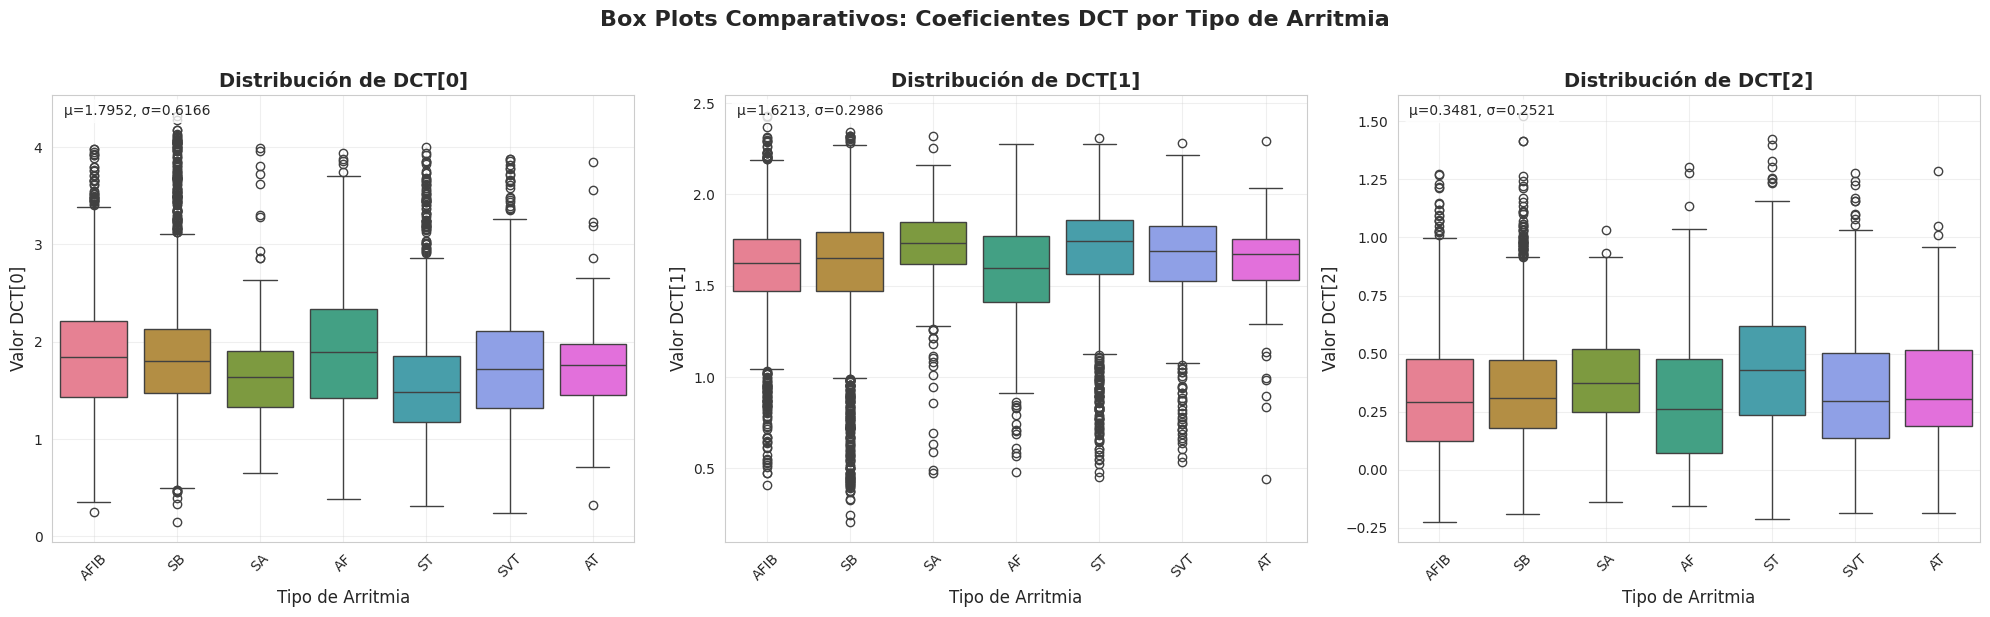


Generando box plots de energía acumulada...


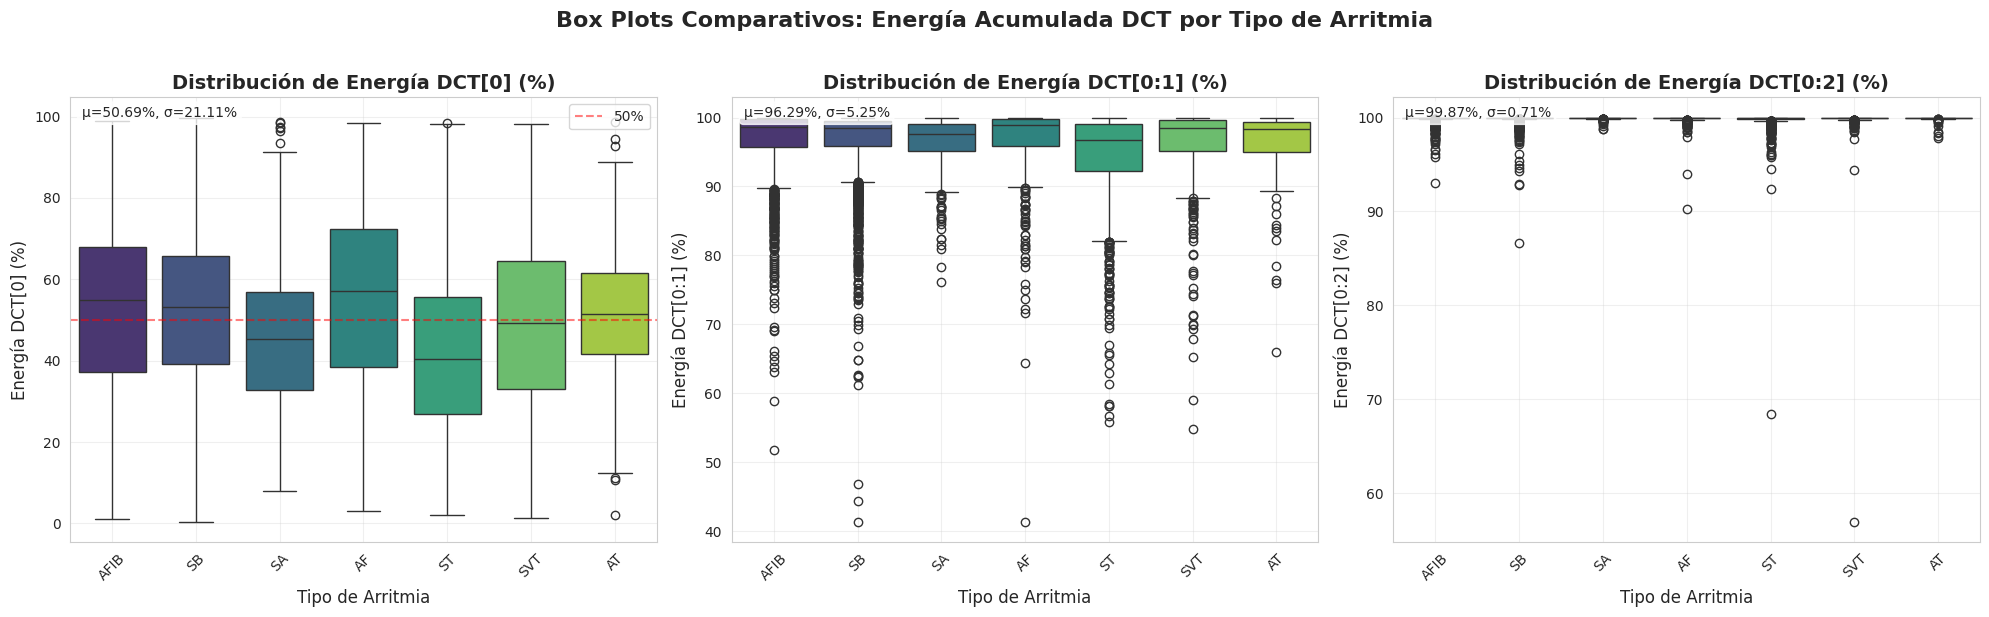

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def create_dct_boxplots(datos_individuales):
    """
    Crea box plots comparativos de los primeros 3 coeficientes DCT por tipo de arritmia
    """
    # Configurar el estilo de seaborn
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (15, 5)

    # Lista de coeficientes DCT a analizar
    dct_coefficients = ['DCT_0', 'DCT_1', 'DCT_2']
    dct_labels = ['DCT[0]', 'DCT[1]', 'DCT[2]']

    # Crear figura con 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Box Plots Comparativos: Coeficientes DCT por Tipo de Arritmia',
                 fontsize=16, fontweight='bold', y=1.02)

    # Obtener lista única de tipos de arritmia y ordenarla
    rhythm_types = sorted(datos_individuales['Rhythm'].unique())

    # Definir paleta de colores
    colors = sns.color_palette("husl", len(rhythm_types))

    for i, (coeff, label) in enumerate(zip(dct_coefficients, dct_labels)):
        # Crear box plot
        box_plot = sns.boxplot(data=datos_individuales, x='Rhythm', y=coeff,
                              ax=axes[i], palette=colors, showfliers=True)

        # Personalizar el subplot
        axes[i].set_title(f'Distribución de {label}', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Tipo de Arritmia', fontsize=12)
        axes[i].set_ylabel(f'Valor {label}', fontsize=12)

        # Rotar etiquetas del eje x para mejor legibilidad
        axes[i].tick_params(axis='x', rotation=45)

        # Agregar grid
        axes[i].grid(True, alpha=0.3)

        # Mostrar estadísticas básicas en el título
        mean_val = datos_individuales[coeff].mean()
        std_val = datos_individuales[coeff].std()
        axes[i].text(0.02, 0.98, f'μ={mean_val:.4f}, σ={std_val:.4f}',
                    transform=axes[i].transAxes, fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                    verticalalignment='top')

    # Ajustar layout
    plt.tight_layout()
    plt.show()

def create_energy_boxplots(datos_individuales):
    """
    Crea box plots comparativos de energía acumulada DCT por tipo de arritmia
    """
    # Configurar el estilo
    sns.set_style("whitegrid")

    # Lista de energías acumuladas a analizar
    energy_coefficients = ['Energy_DCT_0', 'Energy_DCT_01', 'Energy_DCT_012']
    energy_labels = ['Energía DCT[0] (%)', 'Energía DCT[0:1] (%)', 'Energía DCT[0:2] (%)']

    # Crear figura con 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Box Plots Comparativos: Energía Acumulada DCT por Tipo de Arritmia',
                 fontsize=16, fontweight='bold', y=1.02)

    # Obtener lista única de tipos de arritmia y ordenarla
    rhythm_types = sorted(datos_individuales['Rhythm'].unique())

    # Definir paleta de colores
    colors = sns.color_palette("viridis", len(rhythm_types))

    for i, (coeff, label) in enumerate(zip(energy_coefficients, energy_labels)):
        # Crear box plot
        box_plot = sns.boxplot(data=datos_individuales, x='Rhythm', y=coeff,
                              ax=axes[i], palette=colors, showfliers=True)

        # Personalizar el subplot
        axes[i].set_title(f'Distribución de {label}', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Tipo de Arritmia', fontsize=12)
        axes[i].set_ylabel(f'{label}', fontsize=12)

        # Rotar etiquetas del eje x para mejor legibilidad
        axes[i].tick_params(axis='x', rotation=45)

        # Agregar grid
        axes[i].grid(True, alpha=0.3)

        # Mostrar estadísticas básicas en el título
        mean_val = datos_individuales[coeff].mean()
        std_val = datos_individuales[coeff].std()
        axes[i].text(0.02, 0.98, f'μ={mean_val:.2f}%, σ={std_val:.2f}%',
                    transform=axes[i].transAxes, fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                    verticalalignment='top')

        # Agregar línea horizontal en 50% para referencia (solo para energías individuales)
        if i == 0:  # Solo para Energy_DCT_0
            axes[i].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50%')
            axes[i].legend()

    # Ajustar layout
    plt.tight_layout()
    plt.show()

# Función principal para ejecutar todos los análisis
def run_complete_boxplot_analysis(datos_individuales):
    """
    Ejecuta el análisis completo de box plots
    """
    # 1. Box plots de coeficientes DCT
    print("\nGenerando box plots de coeficientes DCT...")
    create_dct_boxplots(datos_individuales)

    # 2. Box plots de energía acumulada
    print("\nGenerando box plots de energía acumulada...")
    create_energy_boxplots(datos_individuales)

if __name__ == "__main__":

    # Ejecutar análisis completo
    run_complete_boxplot_analysis(datos_individuales)

### **3.**
Estudiar, entender, explicar paso a paso (5%) e implementar la extracción
de características usando MFCC. EL algoritmo debe ser implementados
uniendo rutinas de python haciendo el paso a paso (10%).

In [ ]:
import librosa
from tqdm import tqdm

# Ruta a los archivos CSV
data_path = "ecg_data/ECGDataDenoised/"
fs = 500  # Frecuencia de muestreo

# Lista para almacenar características
mfcc_features = []

# Procesamiento
for _, row in tqdm(datos_finales.iterrows(), total=len(datos_finales), desc="Procesando ECGs"):
    archivo = f"{row['FileName']}.csv"
    file_path = os.path.join(data_path, archivo)

    if not os.path.exists(file_path):
        print(f"Archivo no encontrado: {archivo}")
        continue

    try:
        # Cargar la señal ECG
        signal = pd.read_csv(file_path, header=None).iloc[:, 1]
        signal = signal.to_numpy()

        # Quitar NaN e infinitos si hay
        signal = signal[np.isfinite(signal)]

        # Comprobar que la señal no esté vacía luego de limpiar
        if len(signal) == 0:
            raise ValueError("Señal vacía después de eliminar NaN/inf.")

        # Normalizar, evitando división por cero
        std = np.std(signal)
        if std == 0:
            raise ValueError("Desviación estándar cero en la señal.")

        # Normalizar
        signal = (signal - np.mean(signal)) / np.std(signal)

        # Extraer MFCCs con librosa
        mfccs = librosa.feature.mfcc(
            y=signal.astype(np.float32),  # convertir a float32
            sr=fs,
            n_fft=256,
            hop_length=128,
            n_mfcc=13,
            n_mels=40
        )

        # Promediar los coeficientes MFCC
        mfcc_mean = np.mean(mfccs, axis=1)
        tipo_arritmia = row['Rhythm'] if 'Rhythm' in row else np.nan

        # Construir registro de características
        feature_row = {
            'FileName': archivo,
            'tipo_arritmia': row['Rhythm'] if 'Rhythm' in row else np.nan  # más seguro que in
        }

        for i, val in enumerate(mfcc_mean):
            feature_row[f'mfcc_{i+1}'] = val

        # Agregar a la lista
        mfcc_features.append(feature_row)

    except Exception as e:
        print(f"Error en {archivo}: {e}")

# Convertir a DataFrame final
df_mfcc = pd.DataFrame(mfcc_features)

# Mostrar resumen
display(df_mfcc.head())
print(f"Total señales procesadas exitosamente: {len(df_mfcc)}")


Procesando ECGs: 100%|██████████| 8420/8420 [02:28<00:00, 56.83it/s] 


Error en MUSE_20181222_204118_08000.csv: Desviación estándar cero en la señal.
Error en MUSE_20181222_204121_42000.csv: Desviación estándar cero en la señal.
Error en MUSE_20181222_204122_52000.csv: Desviación estándar cero en la señal.
Error en MUSE_20181222_204123_64000.csv: Desviación estándar cero en la señal.
Error en MUSE_20181222_204131_50000.csv: Desviación estándar cero en la señal.
Error en MUSE_20181222_204132_64000.csv: Desviación estándar cero en la señal.
Error en MUSE_20181222_204140_77000.csv: Desviación estándar cero en la señal.
Error en MUSE_20181222_204141_91000.csv: Desviación estándar cero en la señal.
Error en MUSE_20181222_204143_03000.csv: Desviación estándar cero en la señal.
Error en MUSE_20181222_204146_34000.csv: Desviación estándar cero en la señal.
Error en MUSE_20181222_204154_20000.csv: Desviación estándar cero en la señal.
Error en MUSE_20181222_204155_31000.csv: Desviación estándar cero en la señal.
Error en MUSE_20181222_204156_45000.csv: Desviación 

,FileName,tipo_arritmia,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,MUSE_20180113_171327_27000.csv,AFIB,-152.9150,111.3325,50.4537,27.5900,14.9421,8.1919,2.5632,1.5764,1.1818,1.2964,1.6018,1.4785,-0.1467
1,MUSE_20180112_073319_29000.csv,SB,-191.9798,89.3669,56.9074,31.7274,14.4378,4.0188,-0.1078,0.2871,2.4565,3.8592,4.6974,4.0740,2.3428
2,MUSE_20180111_165520_97000.csv,SA,-179.8825,97.5093,56.8663,31.7342,13.6148,4.2696,1.3649,2.0807,3.3475,5.0489,5.1674,4.9647,4.1557
3,MUSE_20180113_121940_44000.csv,SB,-196.3079,80.4676,49.6937,29.9462,14.6804,6.3255,5.1168,6.1429,7.3807,8.6107,8.8005,6.5133,3.3856
4,MUSE_20180112_122850_57000.csv,AF,-130.7889,129.8806,49.5562,26.5216,5.9403,-0.4120,-1.7286,0.4792,1.5205,0.5886,-0.8297,-2.0004,-0.1942


Total señales procesadas exitosamente: 8381


In [ ]:
df_mfcc.to_csv("caracteristicas_mfcc.csv", index=False)

# Parte 3: Comparación de características entre grupos

Comparar las características del punto anterior entre los grupos
apoyándose en gráficos de estadística descriptiva. ¿Qué características
logra mejor discriminación entre grupos? (20%)

In [ ]:
df_features.to_csv("caracteristicas_espectrales.csv", index=False)

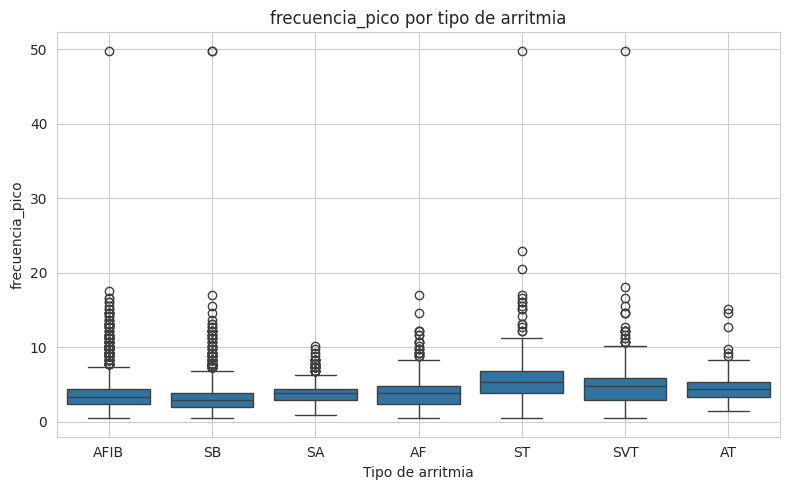

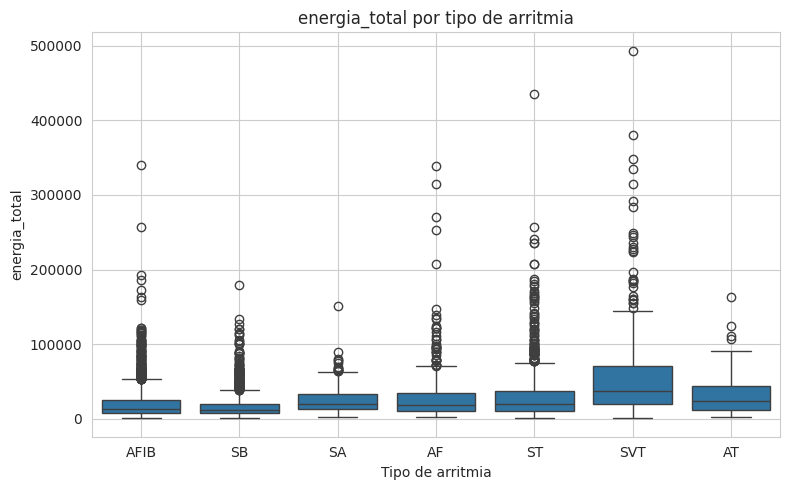

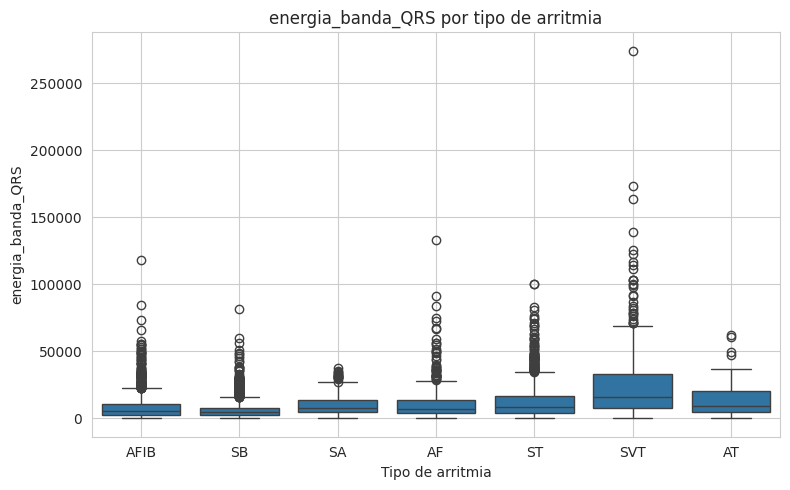

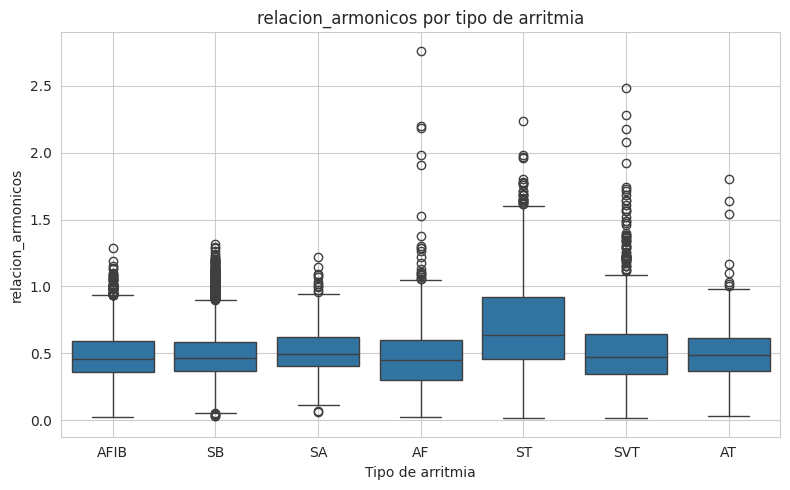

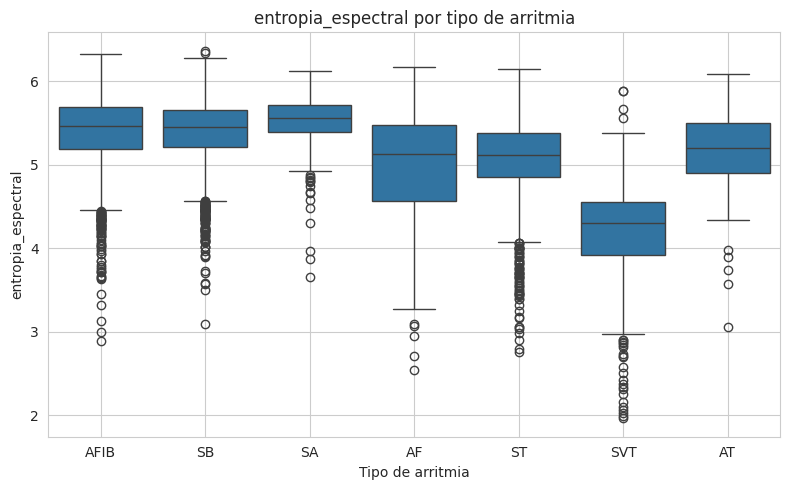

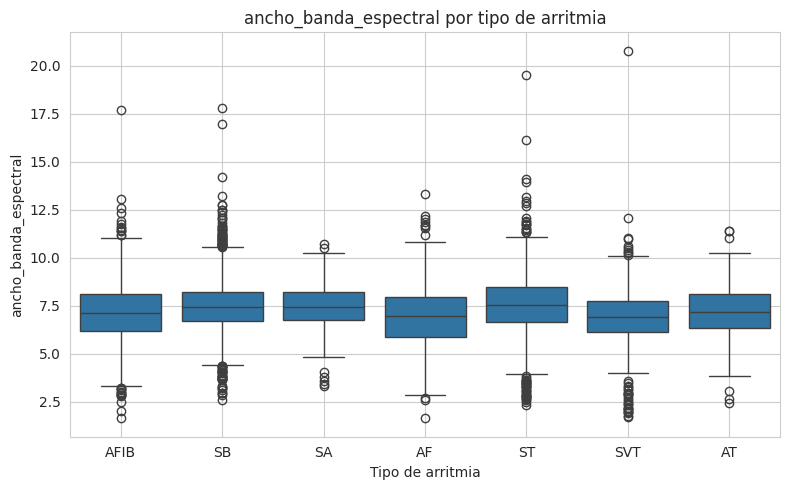

In [ ]:
df_features['ritmo'] = df_features['ritmo'].astype(str)

# Lista de características
caracteristicas = [
    'frecuencia_pico',
    'energia_total',
    'energia_banda_QRS',
    'relacion_armonicos',
    'entropia_espectral',
    'ancho_banda_espectral'
]

# Graficar boxplots por tipo de arritmia
for feature in caracteristicas:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='ritmo', y=feature, data=df_features)
    plt.title(f'{feature} por tipo de arritmia')
    plt.xlabel('Tipo de arritmia')
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Plantear las pruebas de hipótesis que sustenten estadísticamente las
diferencias esperables entre grupos (10%)

### Shapiro-Wilk, Levene y t o Mann Whitney

In [ ]:
caracteristicas = [
    'frecuencia_pico',
    'energia_total',
    'energia_banda_QRS',
    'relacion_armonicos',
    'entropia_espectral',
    'ancho_banda_espectral'
]

for feature in caracteristicas:
    print(f"Análisis de {feature}:")
    print("\nPrueba de normalidad (Shapiro-Wilk):\n")
    _, p_valor_ritmo1 =  stats.shapiro(df_features[df_features['ritmo'] == "AFIB"][feature])
    _, p_valor_ritmo2 =  stats.shapiro(df_features[df_features['ritmo'] == "SB"][feature])
    print(f"{feature} de AFIB: p-value = {p_valor_ritmo1}")
    print(f"{feature} de SB: p-value = {p_valor_ritmo2}")
    if p_valor_ritmo1 > 0.05 and p_valor_ritmo2 > 0.05:
      print("Decisión: No rechazamos la hipótesis nula")
      print(f"Conclusión: {feature} de pacientes con AFIB y SB provienen de distribuciones normales.\n")
    elif p_valor_ritmo1 <= 0.05 and p_valor_ritmo2 <= 0.05:
      print("Decisión: Rechazamos la hipótesis nula")
      print(f"Conclusión: {feature} de pacientes con AFIB y SB no provienen de distribuciones normales.\n")

    print("\nPrueba de homocedasticidad (Levene):\n")
    _, p_valor_levene = stats.levene(df_features[df_features['ritmo'] == "AFIB"][feature], df_features[df_features['ritmo'] == "SB"][feature])
    print(f"Prueba de Levene para {feature}: p-value = {p_valor_levene}")
    if p_valor_levene > 0.05:
      print("Decisión: No rechazamos la hipótesis nula")
      print("Conclusión: Las varianzas de Entropía espectral de pacientes con AFIB y SB son iguales (homocedasticidad).\n")
    else:
      print("Decisión: Rechazamos la hipótesis nula")
      print("Conclusión: Las varianzas de Entropía espectral de pacientes con AFIB y SB difieren significativamente (heterocedasticidad).\n")

    print("\nPrueba de medianas:\n")
    if p_valor_ritmo1 > 0.05 and p_valor_ritmo2 > 0.05 and p_valor_levene > 0.05:
      # Condiciones para prueba t satisfechas
      t_stat, p_value = stats.ttest_ind(df_features[df_features['ritmo'] == "AFIB"][feature], df_features[df_features['ritmo'] == "SB"][feature])
      print(f"Prueba t de {feature}(AFIB vs SB): t = {t_stat}, p-value = {p_value:}")
      alpha = 0.05
      if p_value < alpha:
        print(f"Conclusión: Existe diferencia estadísticamente significativa entre {feature} de pacientes con AFIB y SB.")
      else:
        print(f"Conclusión: No existe diferencia estadísticamente significativa entre {feature} de pacientes con AFIB y SB.")
    else:
      # Usamos prueba no paramétrica en caso de no cumplir las condiciones
      u_stat, p_value = stats.mannwhitneyu(df_features[df_features['ritmo'] == "AFIB"][feature], df_features[df_features['ritmo'] == "SB"][feature])
      print(f"Prueba U de Mann-Whitney de {feature}(AFIB vs SB): U = {u_stat}, p-value = {p_value}")
      alpha = 0.05
      if p_value < alpha:
        print(f"Conclusión: Existe diferencia estadísticamente significativa entre {feature} de pacientes con AFIB y SB.")
      else:
        print(f"Conclusión: No existe diferencia estadísticamente significativa entre {feature} de pacientes con AFIB y SB.")
      print("------------------------------------------------------------------------------------------------------------------------")


Análisis de frecuencia_pico:

Prueba de normalidad (Shapiro-Wilk):

frecuencia_pico de AFIB: p-value = 3.97155747389224e-48
frecuencia_pico de SB: p-value = 1.9658007701988146e-62
Decisión: Rechazamos la hipótesis nula
Conclusión: frecuencia_pico de pacientes con AFIB y SB no provienen de distribuciones normales.


Prueba de homocedasticidad (Levene):

Prueba de Levene para frecuencia_pico: p-value = 0.015404590253055534
Decisión: Rechazamos la hipótesis nula
Conclusión: Las varianzas de Entropía espectral de pacientes con AFIB y SB difieren significativamente (heterocedasticidad).


Prueba de medianas:

Prueba U de Mann-Whitney de frecuencia_pico(AFIB vs SB): U = 4034063.5, p-value = 4.393521425574722e-38
Conclusión: Existe diferencia estadísticamente significativa entre frecuencia_pico de pacientes con AFIB y SB.
------------------------------------------------------------------------------------------------------------------------
Análisis de energia_total:

Prueba de normalidad (Sh



---



Comparación de discriminación de arritmias usando los coeficientes de la Transformada discreta del Coseno

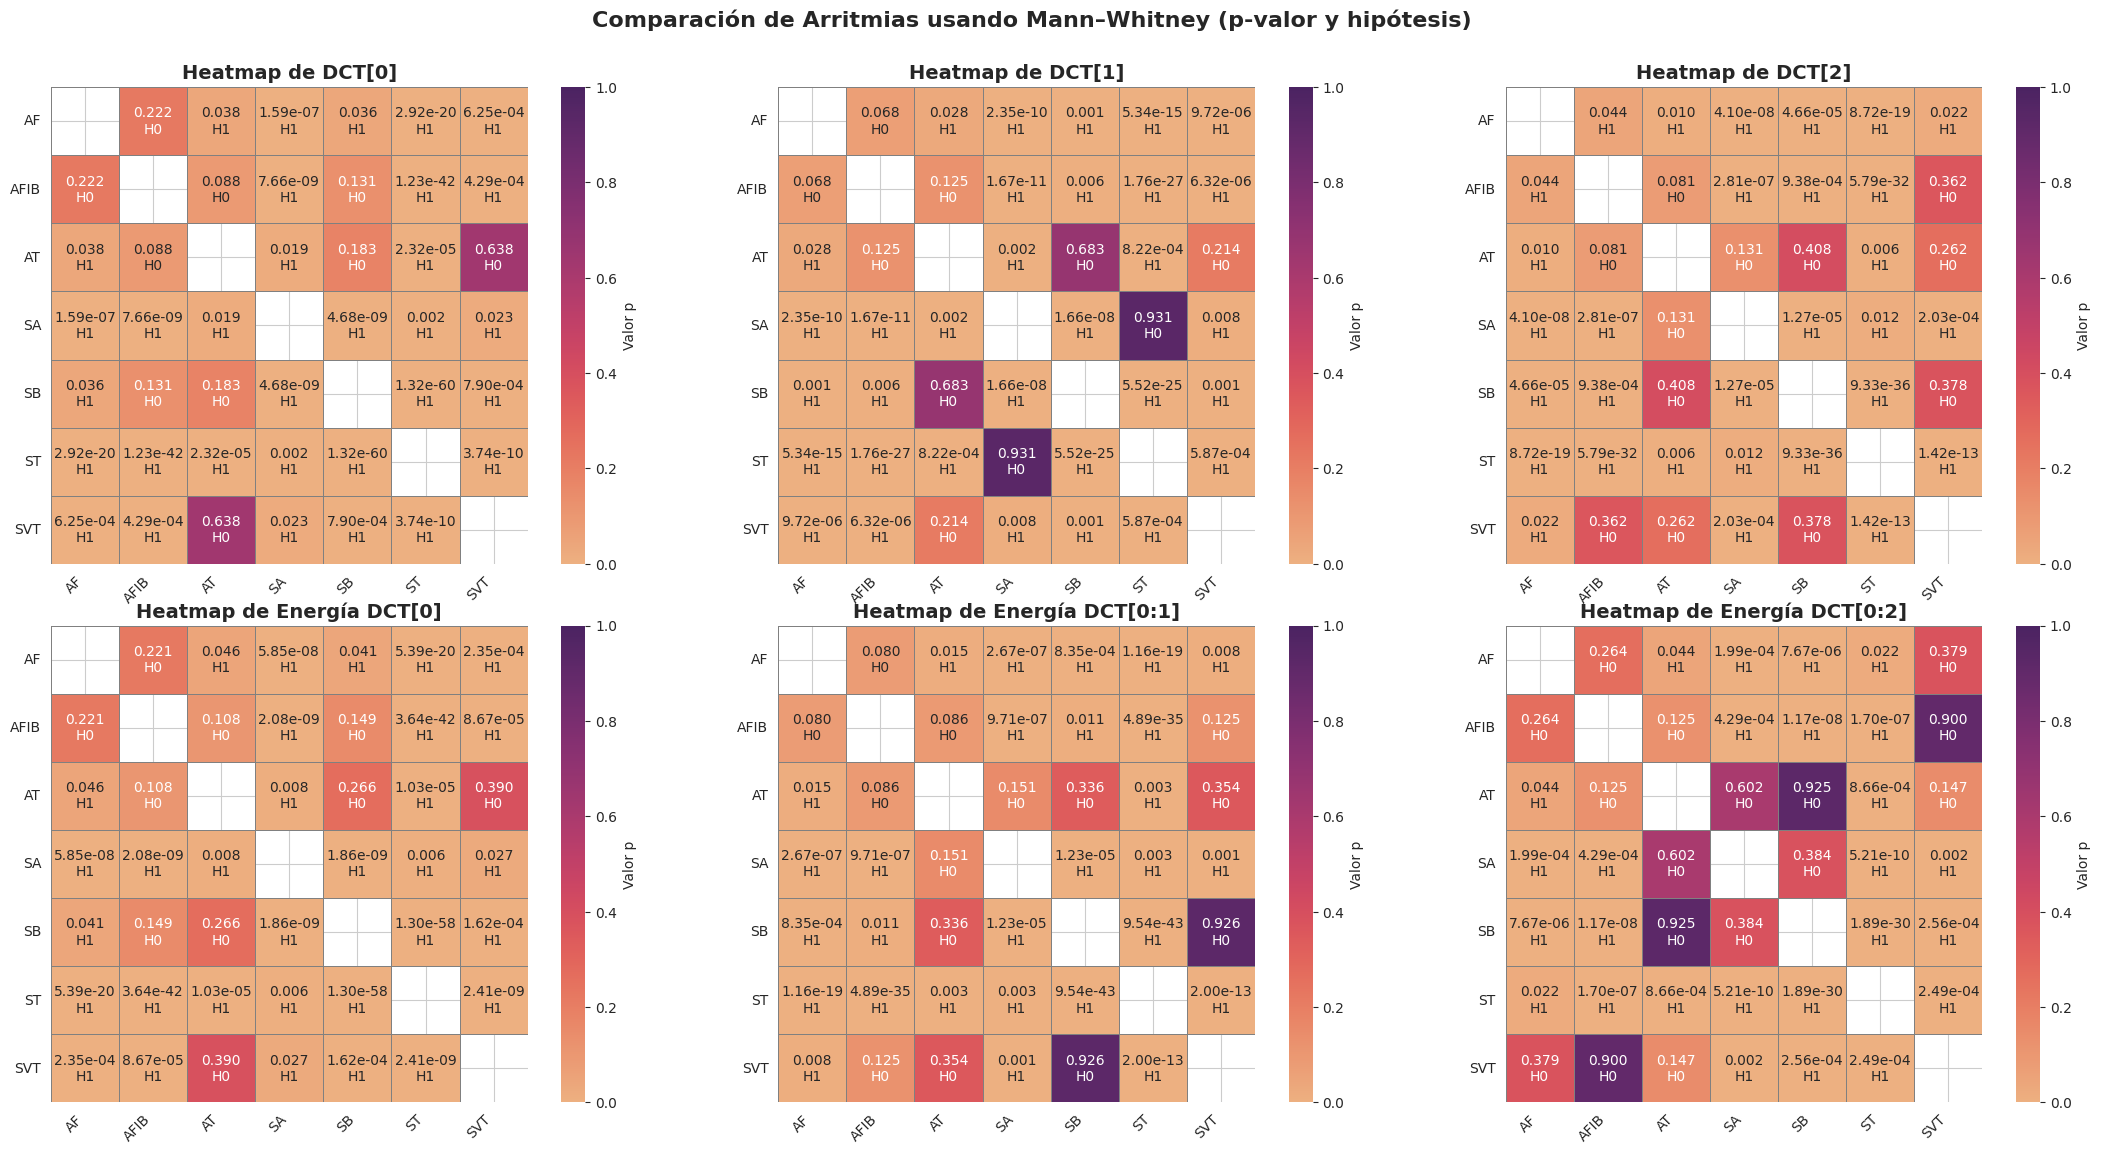

In [ ]:
from scipy.stats import mannwhitneyu
from itertools import combinations
from matplotlib.colors import Normalize
from matplotlib import cm

def generate_mannwhitney_matrices(datos_individuales, alpha=0.05):
    """
    Genera matrices para cada métrica con el valor p y decisión de hipótesis (H0 o H1).
    Devuelve un diccionario con matrices de anotaciones y matrices numéricas para color.
    """

    metrics = ['DCT_0', 'DCT_1', 'DCT_2', 'Energy_DCT_0', 'Energy_DCT_01', 'Energy_DCT_012']
    rhythm_types = sorted(datos_individuales['Rhythm'].dropna().unique())

    annotated_matrices = {}
    numeric_pvalue_matrices = {}

    for metric in metrics:
        matrix_text = pd.DataFrame(index=rhythm_types, columns=rhythm_types, dtype=object)
        matrix_pval = pd.DataFrame(index=rhythm_types, columns=rhythm_types, dtype=float)

        for r1, r2 in combinations(rhythm_types, 2):
            group1 = datos_individuales[datos_individuales['Rhythm'] == r1][metric].dropna()
            group2 = datos_individuales[datos_individuales['Rhythm'] == r2][metric].dropna()

            if len(group1) < 3 or len(group2) < 3:
                text = "ND\nN/A"
                pval = np.nan
            else:
                try:
                    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
                    hypothesis = "H1" if p < alpha else "H0"
                    p_text = f"{p:.2e}" if p < 0.001 else f"{p:.3f}"
                    text = f"{p_text}\n{hypothesis}"
                    pval = p
                except Exception:
                    text = "ERR\nN/A"
                    pval = np.nan

            # Llenar matriz superior
            matrix_text.loc[r1, r2] = text
            matrix_pval.loc[r1, r2] = pval

            # Matriz simétrica
            matrix_text.loc[r2, r1] = text
            matrix_pval.loc[r2, r1] = pval

        # Diagonal
        for r in rhythm_types:
            matrix_text.loc[r, r] = "—"
            matrix_pval.loc[r, r] = np.nan

        annotated_matrices[metric] = matrix_text
        numeric_pvalue_matrices[metric] = matrix_pval

    return annotated_matrices, numeric_pvalue_matrices
def plot_mannwhitney_heatmaps(annotated_matrices, numeric_pvalue_matrices, alpha=0.05):
    """
    Visualiza matrices anotadas con valores p y decisión de hipótesis en formato heatmap.
    """
    fig, axes = plt.subplots(2, 3, figsize=(22, 12))
    axes = axes.flatten()
    cmap = sns.color_palette("flare", as_cmap=True)

    metric_titles = [
        'DCT[0]', 'DCT[1]', 'DCT[2]',
        'Energía DCT[0]', 'Energía DCT[0:1]', 'Energía DCT[0:2]'
    ]

    for i, metric in enumerate(annotated_matrices.keys()):
        ax = axes[i]
        annot = annotated_matrices[metric]
        pvals = numeric_pvalue_matrices[metric]

        sns.heatmap(
            pvals.astype(float),
            cmap=cmap,
            mask=pvals.isnull(),
            annot=annot.values,
            fmt='',
            square=True,
            linewidths=0.5,
            linecolor='gray',
            cbar_kws={'label': 'Valor p'},
            ax=ax,
            vmin=0, vmax=1
        )

        ax.set_title(f"Heatmap de {metric_titles[i]}", fontsize=14, fontweight='bold')
        ax.set_xticklabels(annot.columns, rotation=45, ha='right')
        ax.set_yticklabels(annot.index, rotation=0)

    plt.suptitle("Comparación de Arritmias usando Mann–Whitney (p-valor y hipótesis)", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()
annotated_matrices, numeric_pvalue_matrices = generate_mannwhitney_matrices(datos_individuales)
plot_mannwhitney_heatmaps(annotated_matrices, numeric_pvalue_matrices)

In [ ]:
def generar_tabla_resumen_mannwhitney(numeric_pvalue_matrices, alpha=0.05):
    """
    Genera una tabla resumen con estadísticas clave de las pruebas de Mann-Whitney por métrica.
    """

    resumen_data = []

    for metric, pval_matrix in numeric_pvalue_matrices.items():
        # Extraer valores únicos de la matriz (sin diagonales ni duplicados)
        tril_indices = np.tril_indices_from(pval_matrix, k=-1)
        pvals = pval_matrix.values[tril_indices]
        pvals = pvals[~np.isnan(pvals)]  # eliminar NaNs

        # Separar por hipótesis
        h1_vals = pvals[pvals < alpha]
        h0_vals = pvals[pvals >= alpha]

        total = len(pvals)
        rechazos = len(h1_vals)
        rechazos_pct = (rechazos / total) * 100 if total > 0 else 0

        resumen_data.append({
            'Métrica': metric,
            '% Rechazos H0': f"{rechazos_pct:.1f}%",
            'Promedio p-valor (todas)': np.mean(pvals) if len(pvals) > 0 else np.nan,
            'Promedio p-valor (solo H1)': np.mean(h1_vals) if len(h1_vals) > 0 else np.nan,
            'p-valor máximo': np.max(pvals) if len(pvals) > 0 else np.nan
        })

    resumen_df = pd.DataFrame(resumen_data)
    resumen_df.columns = [
        "Métrica",
        "% Rechazos H0",
        "Promedio p-valor (todas)",
        "Promedio p-valor (solo H1)",
        "p-valor máximo"
    ]

    return resumen_df

In [ ]:
resumen_mannwhitney = generar_tabla_resumen_mannwhitney(numeric_pvalue_matrices)
display(resumen_mannwhitney)

,Métrica,% Rechazos H0,Promedio p-valor (todas),Promedio p-valor (solo H1),p-valor máximo
0,DCT_0,76.2%,0.0657,0.0074,0.6378
1,DCT_1,76.2%,0.0985,0.0030,0.9312
2,DCT_2,71.4%,0.0818,0.0064,0.4081
3,Energy_DCT_0,76.2%,0.0601,0.0080,0.3897
4,Energy_DCT_01,66.7%,0.1000,0.0030,0.9257
5,Energy_DCT_012,61.9%,0.1807,0.0054,0.9252
